# Data Importing

In [1]:
import pandas as pd
from joblib import load

file = load('data_clean.z')
train_ts = file['train']
val_ts = file['val']
test_ts = file['test']

# Preprocessing
Depending on the nature of the models selected for ensembling. More than one preprocessing technique might be selected. In this example, the ensembles are based on regression trees so the preprocessing requirements are the same as in the 'Regression Trees' notebook

In [2]:
import numpy as np

train_ts_processed = train_ts.to_frame().diff()
for l in [1,2,3,24,48]:
    train_ts_processed['lag-{}'.format(l)] = train_ts_processed['cpc'].shift(periods=l)
train_ts_processed.dropna(inplace=True, axis=0)
y = train_ts_processed['cpc'].values
X = train_ts_processed.drop('cpc', axis=1).values
print('feature matrix:\n',X)
print('Target vector:\n',y.reshape(-1,1))

feature matrix:
 [[-0.00882875  0.00263513  0.00571875 -0.02697922  0.0170075 ]
 [ 0.0020447  -0.00882875  0.00263513 -0.0066526  -0.03365829]
 [ 0.00111814  0.0020447  -0.00882875 -0.01484984  0.00534889]
 ...
 [ 0.00356583 -0.01195189 -0.00545777 -0.00321909 -0.0195469 ]
 [ 0.00650718  0.00356583 -0.01195189  0.00358975  0.01004682]
 [-0.00387172  0.00650718  0.00356583 -0.02673232 -0.00897452]]
Target vector:
 [[ 0.0020447 ]
 [ 0.00111814]
 [-0.00859562]
 ...
 [ 0.00650718]
 [-0.00387172]
 [-0.00665327]]


# Fitting & Ensembling
The Science-Kit Machine Learning library contains a predefined pipelines of ensemble learners  (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble). Alternatively, the users may ensemble different models not included in the SK-Learn library, for example, by averaging the results obtained from both SARIMA and PyFlux ARIMA models. 
In this example, use a Random Forest which is an ensemble of decision trees models fit on random subsets of the data

In [31]:
from sklearn.ensemble import RandomForestRegressor
import time

rfr = RandomForestRegressor(max_depth=3, n_estimators=10)
start = time.time()
rfr = rfr.fit(X, y)
print('fitting complete after {} seconds'.format(time.time()-start))

fitting complete after 0.01999807357788086 seconds


# Forecasting
In this example, conduct the forecast on a rolling basis:

In [32]:
from datetime import timedelta

forecasts = pd.DataFrame(columns=train_ts_processed.columns, index=val_ts.index)
attached_df = pd.concat([train_ts_processed[-48:], forecasts], axis=0)
for t in forecasts.index:
    for l in [1,2,3,24,48]:
        forecasts.loc[t, 'lag-{}'.format(l)] = attached_df.loc[t - timedelta(hours=l), 'cpc']
    step_X = forecasts.loc[t].values[1:].reshape(1,-1)
    step_y = rfr.predict(step_X)[0]
    attached_df.loc[t, 'cpc'], forecasts.loc[t, 'cpc'] = step_y, step_y

forecasts.head()

,cpc,lag-1,lag-2,lag-3,lag-24,lag-48
timestamp,,,,,,
2011-08-14 03:00:00,-0.00380121,-0.00665327,-0.00387172,0.00650718,-0.010359,0.00154876
2011-08-14 04:00:00,0.012166,-0.00380121,-0.00665327,-0.00387172,0.0144919,0.0268069
2011-08-14 05:00:00,0.00931566,0.012166,-0.00380121,-0.00665327,0.0126438,0.0150717
2011-08-14 06:00:00,0.0110425,0.00931566,0.012166,-0.00380121,0.0417596,0.000228741
2011-08-14 07:00:00,0.0313097,0.0110425,0.00931566,0.012166,0.0379464,0.0308431


Note that the forecasts need to be re-trended

In [33]:
forecasts['cpc'][0] = forecasts['cpc'][0] + train_ts[-1]
forecasts['cpc'] = forecasts['cpc'].cumsum()
forecasts['cpc'].head()

timestamp
2011-08-14 03:00:00    0.0896484
2011-08-14 04:00:00     0.101814
2011-08-14 05:00:00      0.11113
2011-08-14 06:00:00     0.122172
2011-08-14 07:00:00     0.153482
Freq: H, Name: cpc, dtype: object

# Validation
Coompare forecasts against the hold-out validation set

Text(0.5, 1.0, 'MSE: 0.010060115261136536')

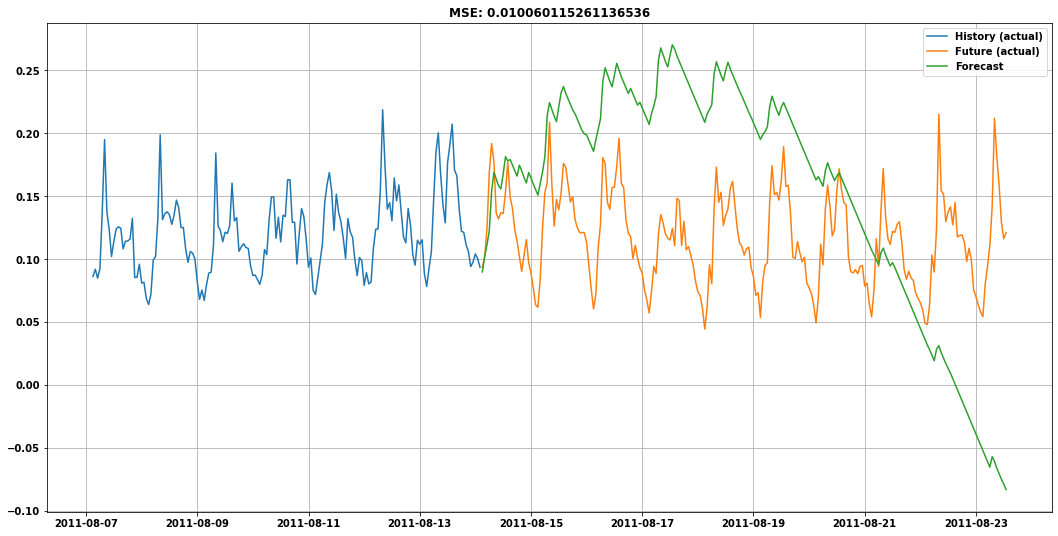

In [34]:
import matplotlib.pyplot as plt

mse = ((val_ts.values - forecasts['cpc'].values)**2).mean()

plt.figure(figsize=(18,9))
plt.plot(train_ts[-24*7:], label='History (actual)')
plt.plot(val_ts, label='Future (actual)')
plt.plot(forecasts['cpc'], label='Forecast')
plt.legend()
plt.grid()
plt.title('MSE: '+ str(mse))

Notice that the accuracy is slightly better than the Decition Tree example (0.010 vs 0.012), but the forecasts are still off. Ideally, Random forests perform better with more features in the data set and better hyperparameter tuning (e.g. gridsearch). Also notice how the forecast is less noisy for random forests due to increased ability to 'generalize'.